In [78]:
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot, mask
import os
import geopandas as gpd
from matplotlib.patches import Rectangle
from matplotlib_scalebar.scalebar import ScaleBar
import xarray as xr

In [79]:
dem_data = '/home/jovyan/jupyterbook/book/modules/07_Raster2_DEMs_Warp_Clip_Sample/dem_data'

dem_fn = os.path.join(dem_data, "WA_COP90.tif")

dst_crs = 'EPSG:32610'

proj_fn_lzw = os.path.splitext(dem_fn)[0]+'_utm_gdalwarp_lzw.tif'

if not os.path.exists(proj_fn_lzw):
    !gdalwarp -r cubic -t_srs $dst_crs -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER $out_fn $proj_fn_lzw

src_proj = rio.open(proj_fn_lzw)

In [80]:
hs_fn = os.path.splitext(proj_fn_lzw)[0]+'_hs.tif'

if not os.path.exists(hs_fn):
    !gdaldem hillshade $proj_fn_lzw $hs_fn

hs_src = rio.open(hs_fn)
hs = hs_src.read(1, masked=True)

hs_extent = rio.plot.plotting_extent(hs_src)

In [81]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
#Reproject to match raster
states_gdf_proj = states_gdf.to_crs(src_proj.crs)
#Isolate WA state
wa_state = states_gdf_proj.loc[states_gdf_proj['NAME'] == 'Washington']
#Extract geometry to use for clipping
wa_geom = wa_state.iloc[0].geometry

rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}

wa_ma, wa_ma_transform = rio.mask.mask(src_proj, wa_geom.geoms, **rio_mask_kwargs)

wa_ma_extent = rio.plot.plotting_extent(wa_ma, wa_ma_transform)

In [88]:
# Load era5 points
ds = xr.open_dataset('./era5_2018.nc')
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values
era5_df = ds.to_dataframe().reset_index()
era5_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(era5_df.longitude, era5_df.latitude))

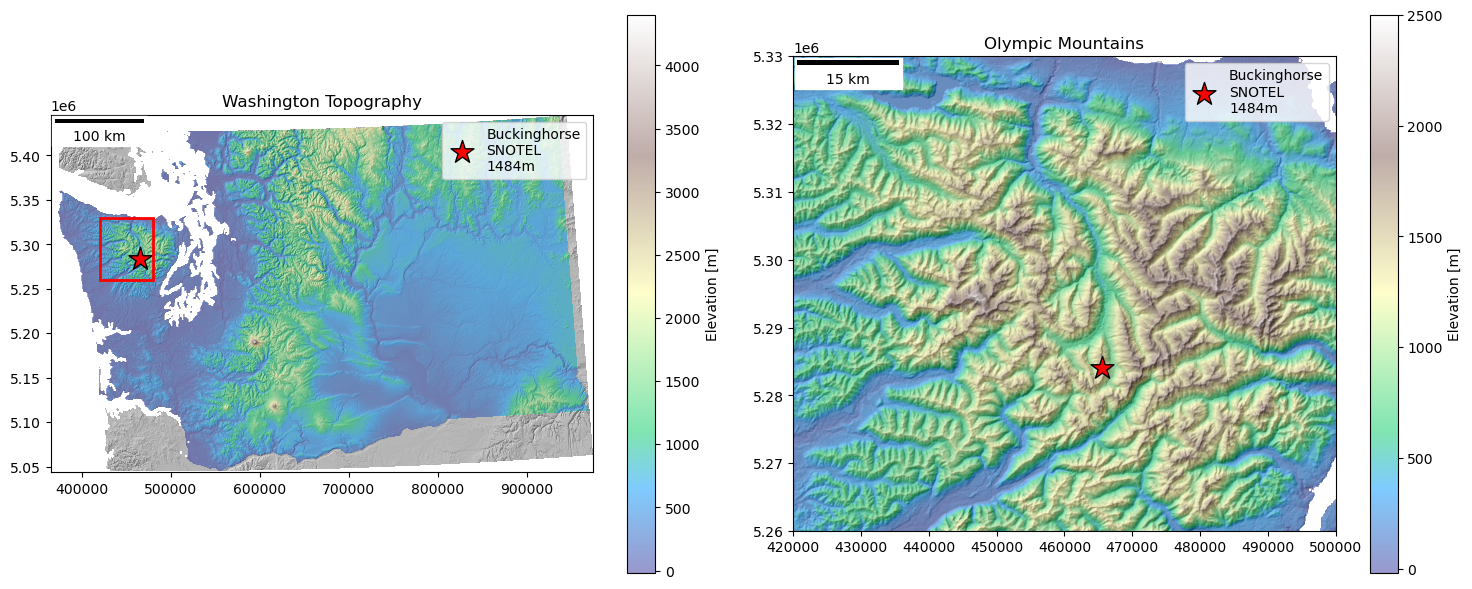

In [77]:
f, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].imshow(hs, cmap='gray', extent=hs_extent)
a = ax[0].imshow(wa_ma, extent=wa_ma_extent, alpha=0.5, cmap='terrain')
cbar = plt.colorbar(a, label='Elevation [m]')
ax[0].scatter(4.655e5, 5.284e6, c='r', marker='*', ec='k', s=300, label='Buckinghorse\nSNOTEL\n1484m')
ax[0].legend()
rect = Rectangle((4.2e5, 5.26e6), 6e4, 7e4, linewidth=2, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)
ax[0].add_artist(ScaleBar(1, units='m', location='upper left'))
ax[0].set_title('Washington Topography')

ax[1].imshow(hs, cmap='gray', extent=hs_extent)
a = ax[1].imshow(wa_ma, extent=wa_ma_extent, alpha=0.5, cmap='terrain', vmax=2500)
cbar = plt.colorbar(a, label='Elevation [m]')
ax[1].add_artist(ScaleBar(1, units='m', location='upper left'))
ax[1].scatter(4.655e5, 5.284e6, c='r', marker='*', ec='k', s=300, label='Buckinghorse\nSNOTEL\n1484m')
ax[1].set_xlim(4.2e5,5e5)
ax[1].set_ylim(5.26e6, 5.33e6)
ax[1].legend()
ax[1].set_title('Olympic Mountains')
ax[1].scatter(era5_gdf.geometry.x, era5_gdf.geometry.y

plt.tight_layout()
plt.savefig('./WA_OLY_DEM.jpeg', dpi=200);